/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Calculating LPIPS scores for images in: ../neosr/experiments/train_plksr_tiny_4x/visualization
This may take a while depending on the number of images...

Setting up LPIPS model...
Using GPU for LPIPS calculation
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pa

Found 162 frame folders
Pre-scanning images for progress estimation...


Scanning frames:   0%|          | 0/162 [00:00<?, ?it/s]

Total images to process: 2312


Calculating LPIPS:   0%|          | 0/2312 [00:00<?, ?img/s]

Using highest iteration as reference for 141017_frame000000: 141017_frame000000_75000.png
Completed frame 141017_frame000000: 14 images, 1.58s per image
Using highest iteration as reference for 141017_frame000001: 141017_frame000001_75000.png
Completed frame 141017_frame000001: 14 images, 1.62s per image
Using highest iteration as reference for 141017_frame000002: 141017_frame000002_75000.png
Completed frame 141017_frame000002: 14 images, 1.66s per image
Using highest iteration as reference for 141017_frame000003: 141017_frame000003_75000.png
Completed frame 141017_frame000003: 14 images, 1.65s per image
Using highest iteration as reference for 141017_frame000004: 141017_frame000004_75000.png
Completed frame 141017_frame000004: 14 images, 1.54s per image
Using highest iteration as reference for 141017_frame000005: 141017_frame000005_75000.png
Completed frame 141017_frame000005: 14 images, 1.41s per image
Using highest iteration as reference for 141017_frame000006: 141017_frame000006_75

/tmp/ipykernel_4703/4263693402.py:341: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=sorted(iterations_with_multiple))


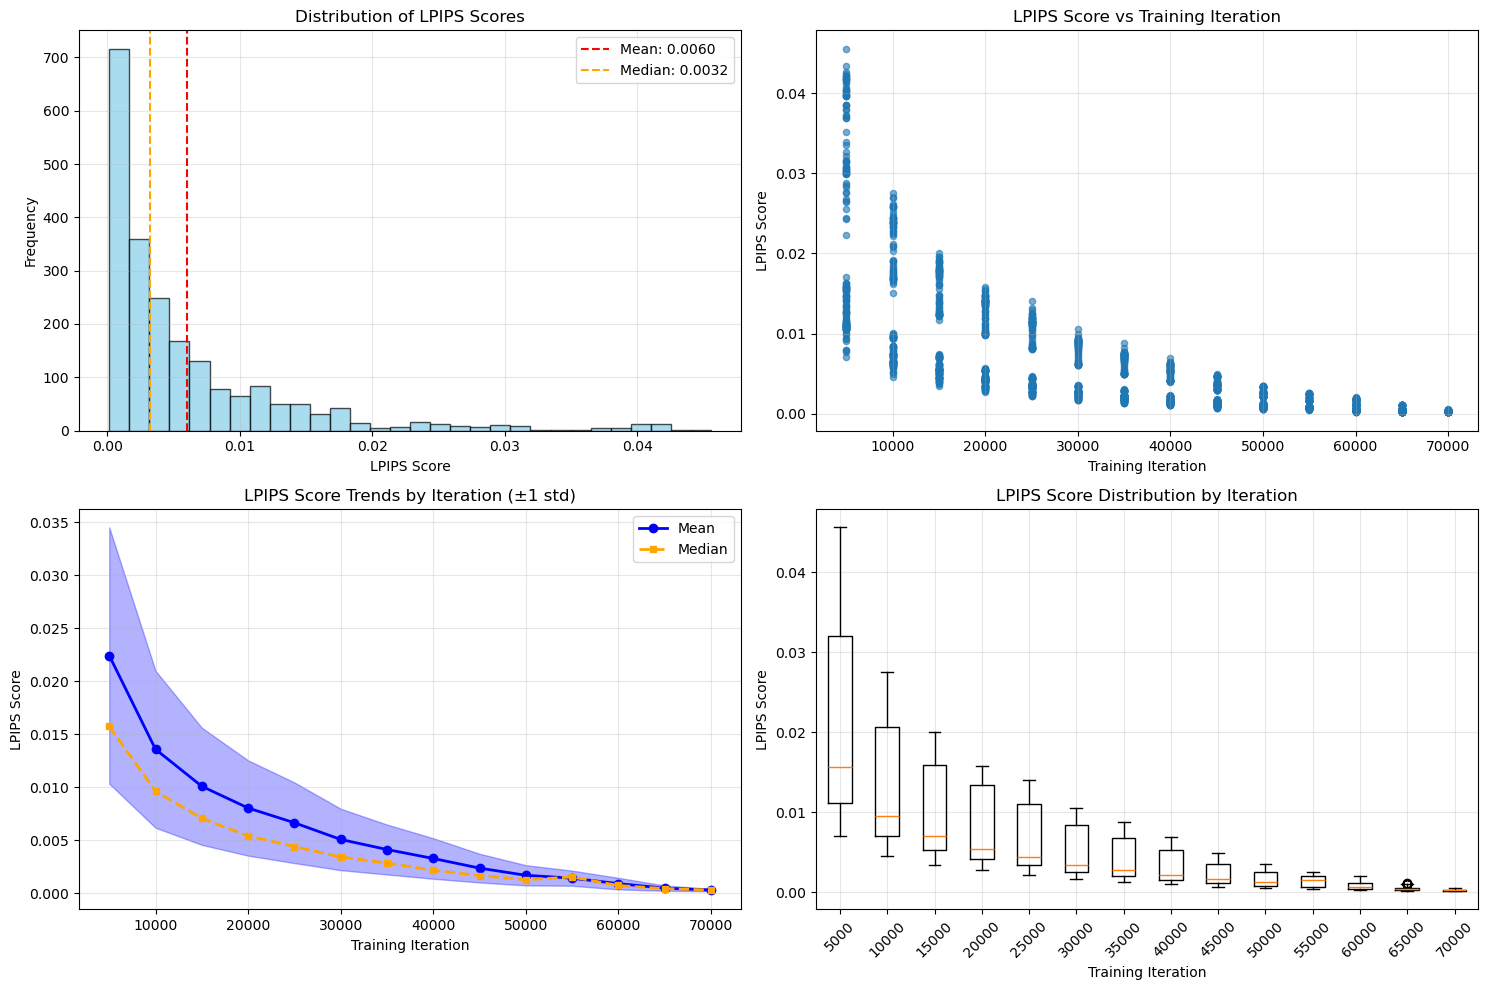

Iteration statistics saved to lpips_iteration_stats.csv


In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta

# Install required packages if not already installed
try:
    import lpips
except ImportError:
    print("Installing LPIPS...")
    import subprocess
    subprocess.check_call(["pip", "install", "lpips"])
    import lpips

try:
    from tqdm.auto import tqdm
except ImportError:
    print("Installing tqdm for progress bars...")
    import subprocess
    subprocess.check_call(["pip", "install", "tqdm"])
    from tqdm.auto import tqdm

def setup_lpips_model(net='alex', device='cuda'):
    """
    Initialize LPIPS model
    Args:
        net: Network to use ('alex', 'vgg', 'squeeze')
        device: Device to run on ('cuda' or 'cpu')
    """
    if torch.cuda.is_available() and device == 'cuda':
        device = 'cuda'
        print(f"Using GPU for LPIPS calculation")
    else:
        device = 'cpu'
        print(f"Using CPU for LPIPS calculation")
    
    loss_fn = lpips.LPIPS(net=net).to(device)
    return loss_fn, device

def load_and_preprocess_image(image_path, device='cuda'):
    """
    Load and preprocess image for LPIPS calculation
    """
    try:
        # Load image
        img = Image.open(image_path).convert('RGB')
        
        # Convert to tensor and normalize to [-1, 1]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        img_tensor = transform(img).unsqueeze(0).to(device)
        return img_tensor
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def extract_iteration_number(filename):
    """
    Extract iteration number from filename
    Expected format: frame_name_XXXXX.png where XXXXX is the iteration
    """
    match = re.search(r'_(\d+)\.png$', filename)
    if match:
        return int(match.group(1))
    return None

def find_reference_image(frame_folder, frame_name):
    """
    Find the reference (ground truth) image for a frame
    This assumes the reference is either the original input or highest iteration
    Modify this function based on your specific setup
    """
    # Look for common reference image patterns
    possible_refs = [
        f"{frame_name}_gt.png",      # Ground truth
        f"{frame_name}_ref.png",     # Reference
        f"{frame_name}_original.png", # Original
        f"{frame_name}.png",         # Base name
    ]
    
    for ref_name in possible_refs:
        ref_path = os.path.join(frame_folder, ref_name)
        if os.path.exists(ref_path):
            return ref_path
    
    # If no explicit reference found, use the image with highest iteration number
    all_images = glob.glob(os.path.join(frame_folder, f"{frame_name}_*.png"))
    if all_images:
        iterations = [(extract_iteration_number(os.path.basename(img)), img) for img in all_images]
        iterations = [(it, path) for it, path in iterations if it is not None]
        if iterations:
            highest_iter_path = max(iterations, key=lambda x: x[0])[1]
            print(f"Using highest iteration as reference for {frame_name}: {os.path.basename(highest_iter_path)}")
            return highest_iter_path
    
    return None

def calculate_lpips_scores(base_path, reference_type='auto'):
    """
    Calculate LPIPS scores for all validation images
    
    Args:
        base_path: Path to visualization folder
        reference_type: 'auto', 'highest_iter', or 'ground_truth'
    """
    print("Setting up LPIPS model...")
    loss_fn, device = setup_lpips_model()
    
    results = []
    frame_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    
    print(f"Found {len(frame_folders)} frame folders")
    
    # Pre-scan to count total number of images for progress estimation
    total_images = 0
    frame_image_counts = {}
    
    print("Pre-scanning images for progress estimation...")
    for frame_name in tqdm(frame_folders, desc="Scanning frames", leave=False):
        frame_folder = os.path.join(base_path, frame_name)
        pattern = os.path.join(frame_folder, f"{frame_name}_*.png")
        val_images = glob.glob(pattern)
        
        valid_images = 0
        for val_img_path in val_images:
            iteration = extract_iteration_number(os.path.basename(val_img_path))
            if iteration is not None:
                valid_images += 1
        
        frame_image_counts[frame_name] = valid_images
        total_images += valid_images
    
    print(f"Total images to process: {total_images}")
    
    # Initialize progress tracking
    processed_images = 0
    start_time = time.time()
    
    # Create main progress bar
    main_pbar = tqdm(total=total_images, desc="Calculating LPIPS", unit="img")
    
    for frame_name in frame_folders:
        frame_folder = os.path.join(base_path, frame_name)
        
        # Find reference image
        ref_path = find_reference_image(frame_folder, frame_name)
        if ref_path is None:
            tqdm.write(f"Warning: No reference image found for {frame_name}, skipping...")
            # Update progress bar for skipped images
            main_pbar.update(frame_image_counts[frame_name])
            processed_images += frame_image_counts[frame_name]
            continue
        
        # Load reference image
        ref_tensor = load_and_preprocess_image(ref_path, device)
        if ref_tensor is None:
            main_pbar.update(frame_image_counts[frame_name])
            processed_images += frame_image_counts[frame_name]
            continue
        
        # Find all validation images for this frame
        pattern = os.path.join(frame_folder, f"{frame_name}_*.png")
        val_images = glob.glob(pattern)
        
        frame_start_time = time.time()
        frame_processed = 0
        
        for val_img_path in val_images:
            iteration = extract_iteration_number(os.path.basename(val_img_path))
            if iteration is None:
                continue
            
            # Skip if this is the reference image
            if val_img_path == ref_path:
                continue
            
            # Load validation image
            val_tensor = load_and_preprocess_image(val_img_path, device)
            if val_tensor is None:
                main_pbar.update(1)
                processed_images += 1
                frame_processed += 1
                continue
            
            # Calculate LPIPS score
            try:
                with torch.no_grad():
                    lpips_score = loss_fn(ref_tensor, val_tensor).item()
                
                results.append({
                    'frame': frame_name,
                    'iteration': iteration,
                    'lpips_score': lpips_score,
                    'image_path': val_img_path,
                    'reference_path': ref_path
                })
                
                # Update progress
                processed_images += 1
                frame_processed += 1
                main_pbar.update(1)
                
                # Calculate and display time estimates
                elapsed_time = time.time() - start_time
                if processed_images > 0:
                    avg_time_per_image = elapsed_time / processed_images
                    remaining_images = total_images - processed_images
                    estimated_remaining_time = avg_time_per_image * remaining_images
                    
                    eta = datetime.now() + timedelta(seconds=estimated_remaining_time)
                    
                    main_pbar.set_postfix({
                        'Frame': frame_name[:10] + '...' if len(frame_name) > 10 else frame_name,
                        'Iter': iteration,
                        'LPIPS': f"{lpips_score:.4f}",
                        'ETA': eta.strftime('%H:%M:%S')
                    })
                
            except Exception as e:
                tqdm.write(f"Error calculating LPIPS for {val_img_path}: {e}")
                main_pbar.update(1)
                processed_images += 1
                frame_processed += 1
        
        # Log frame completion
        frame_time = time.time() - frame_start_time
        if frame_processed > 0:
            avg_time_per_frame_image = frame_time / frame_processed
            tqdm.write(f"Completed frame {frame_name}: {frame_processed} images, "
                      f"{avg_time_per_frame_image:.2f}s per image")
    
    main_pbar.close()
    
    # Final timing summary
    total_time = time.time() - start_time
    print(f"\nProcessing complete!")
    print(f"Total time: {timedelta(seconds=int(total_time))}")
    print(f"Average time per image: {total_time/max(processed_images, 1):.2f} seconds")
    print(f"Successfully processed: {len(results)} images")
    
    return pd.DataFrame(results)

def analyze_and_visualize_results(df):
    """
    Analyze LPIPS results and create visualizations
    """
    if df.empty:
        print("No results to analyze!")
        return
    
    print(f"\n{'='*60}")
    print(f"ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Total LPIPS scores calculated: {len(df)}")
    print(f"Number of unique frames: {df['frame'].nunique()}")
    print(f"Number of unique iterations: {df['iteration'].nunique()}")
    print(f"Iteration range: {df['iteration'].min()} - {df['iteration'].max()}")
    print()
    print(f"LPIPS Score Statistics:")
    print(f"  Average: {df['lpips_score'].mean():.4f}")
    print(f"  Median:  {df['lpips_score'].median():.4f}")
    print(f"  Best (lowest):  {df['lpips_score'].min():.4f}")
    print(f"  Worst (highest): {df['lpips_score'].max():.4f}")
    print(f"  Standard deviation: {df['lpips_score'].std():.4f}")
    
    # Group by iteration
    print(f"\nProcessing iteration statistics...")
    iter_stats = df.groupby('iteration')['lpips_score'].agg(['mean', 'median', 'std', 'count']).reset_index()
    iter_stats = iter_stats.sort_values('iteration')
    
    print(f"\nLPIPS Scores by Training Iteration:")
    print(f"{'Iteration':<10} {'Mean':<8} {'Median':<8} {'Std':<8} {'Count':<6}")
    print(f"{'-'*50}")
    for _, row in iter_stats.iterrows():
        print(f"{row['iteration']:<10} {row['mean']:<8.4f} {row['median']:<8.4f} {row['std']:<8.4f} {row['count']:<6.0f}")
    
    # Find best and worst performing iterations
    best_iter = iter_stats.loc[iter_stats['mean'].idxmin()]
    worst_iter = iter_stats.loc[iter_stats['mean'].idxmax()]
    
    print(f"\nBest performing iteration: {best_iter['iteration']} (Mean LPIPS: {best_iter['mean']:.4f})")
    print(f"Worst performing iteration: {worst_iter['iteration']} (Mean LPIPS: {worst_iter['mean']:.4f})")
    
    print(f"\nGenerating visualizations...")
    
    # Create visualizations with progress
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. LPIPS score distribution
    axes[0, 0].hist(df['lpips_score'], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0, 0].axvline(df['lpips_score'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["lpips_score"].mean():.4f}')
    axes[0, 0].axvline(df['lpips_score'].median(), color='orange', linestyle='--', 
                      label=f'Median: {df["lpips_score"].median():.4f}')
    axes[0, 0].set_xlabel('LPIPS Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of LPIPS Scores')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. LPIPS vs Iteration (scatter plot)
    axes[0, 1].scatter(df['iteration'], df['lpips_score'], alpha=0.6, s=20)
    axes[0, 1].set_xlabel('Training Iteration')
    axes[0, 1].set_ylabel('LPIPS Score')
    axes[0, 1].set_title('LPIPS Score vs Training Iteration')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Average LPIPS by iteration (line plot)
    axes[1, 0].plot(iter_stats['iteration'], iter_stats['mean'], marker='o', linewidth=2, 
                   markersize=6, color='blue', label='Mean')
    axes[1, 0].fill_between(iter_stats['iteration'], 
                           iter_stats['mean'] - iter_stats['std'], 
                           iter_stats['mean'] + iter_stats['std'], 
                           alpha=0.3, color='blue')
    axes[1, 0].plot(iter_stats['iteration'], iter_stats['median'], marker='s', linewidth=2, 
                   markersize=4, color='orange', linestyle='--', label='Median')
    axes[1, 0].set_xlabel('Training Iteration')
    axes[1, 0].set_ylabel('LPIPS Score')
    axes[1, 0].set_title('LPIPS Score Trends by Iteration (±1 std)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Box plot by iteration (for iterations with multiple frames)
    iterations_with_multiple = iter_stats[iter_stats['count'] > 1]['iteration'].tolist()
    if len(iterations_with_multiple) > 1:
        df_multi = df[df['iteration'].isin(iterations_with_multiple)]
        box_data = [df_multi[df_multi['iteration'] == it]['lpips_score'].values 
                   for it in sorted(iterations_with_multiple)]
        axes[1, 1].boxplot(box_data, labels=sorted(iterations_with_multiple))
        axes[1, 1].set_xlabel('Training Iteration')
        axes[1, 1].set_ylabel('LPIPS Score')
        axes[1, 1].set_title('LPIPS Score Distribution by Iteration')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data for box plot\n(Need multiple frames per iteration)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Box Plot (Insufficient Data)')
    
    plt.tight_layout()
    plt.show()
    
    return iter_stats

# Main execution
def main():
    # Configuration
    base_path = "../neosr/experiments/train_plksr_tiny_4x/visualization"
    
    # Check if path exists
    if not os.path.exists(base_path):
        print(f"Error: Path {base_path} does not exist!")
        print("Please update the base_path variable with the correct path to your visualization folder.")
        return
    
    print(f"Calculating LPIPS scores for images in: {base_path}")
    print("This may take a while depending on the number of images...\n")
    
    # Calculate LPIPS scores
    results_df = calculate_lpips_scores(base_path)
    
    if results_df.empty:
        print("No LPIPS scores calculated. Please check your image paths and naming convention.")
        return
    
    # Save results
    output_file = "lpips_results.csv"
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")
    
    # Analyze and visualize
    iteration_stats = analyze_and_visualize_results(results_df)
    
    # Save iteration statistics
    iteration_stats.to_csv("lpips_iteration_stats.csv", index=False)
    print(f"Iteration statistics saved to lpips_iteration_stats.csv")
    
    return results_df, iteration_stats

# Run the analysis
if __name__ == "__main__":
    results_df, iteration_stats = main()

CORRECTED LPIPS ANALYSIS - VALID ITERATIONS ONLY
Filtering out collapsed model iterations (60K+)
Focus: 5K-55K iterations (stable training phase)
Original data: 14 iterations
Valid data (pre-collapse): 8 iterations
Filtered range: 35000K - 70000K

📊 Valid Data Summary:
  Iterations: 35K - 70K
  LPIPS Range: 0.000287 - 0.004108
  Total Variation: 0.003821
  Relative Variation: 211.742%

Generating corrected plots...
Creating detailed analysis plots...


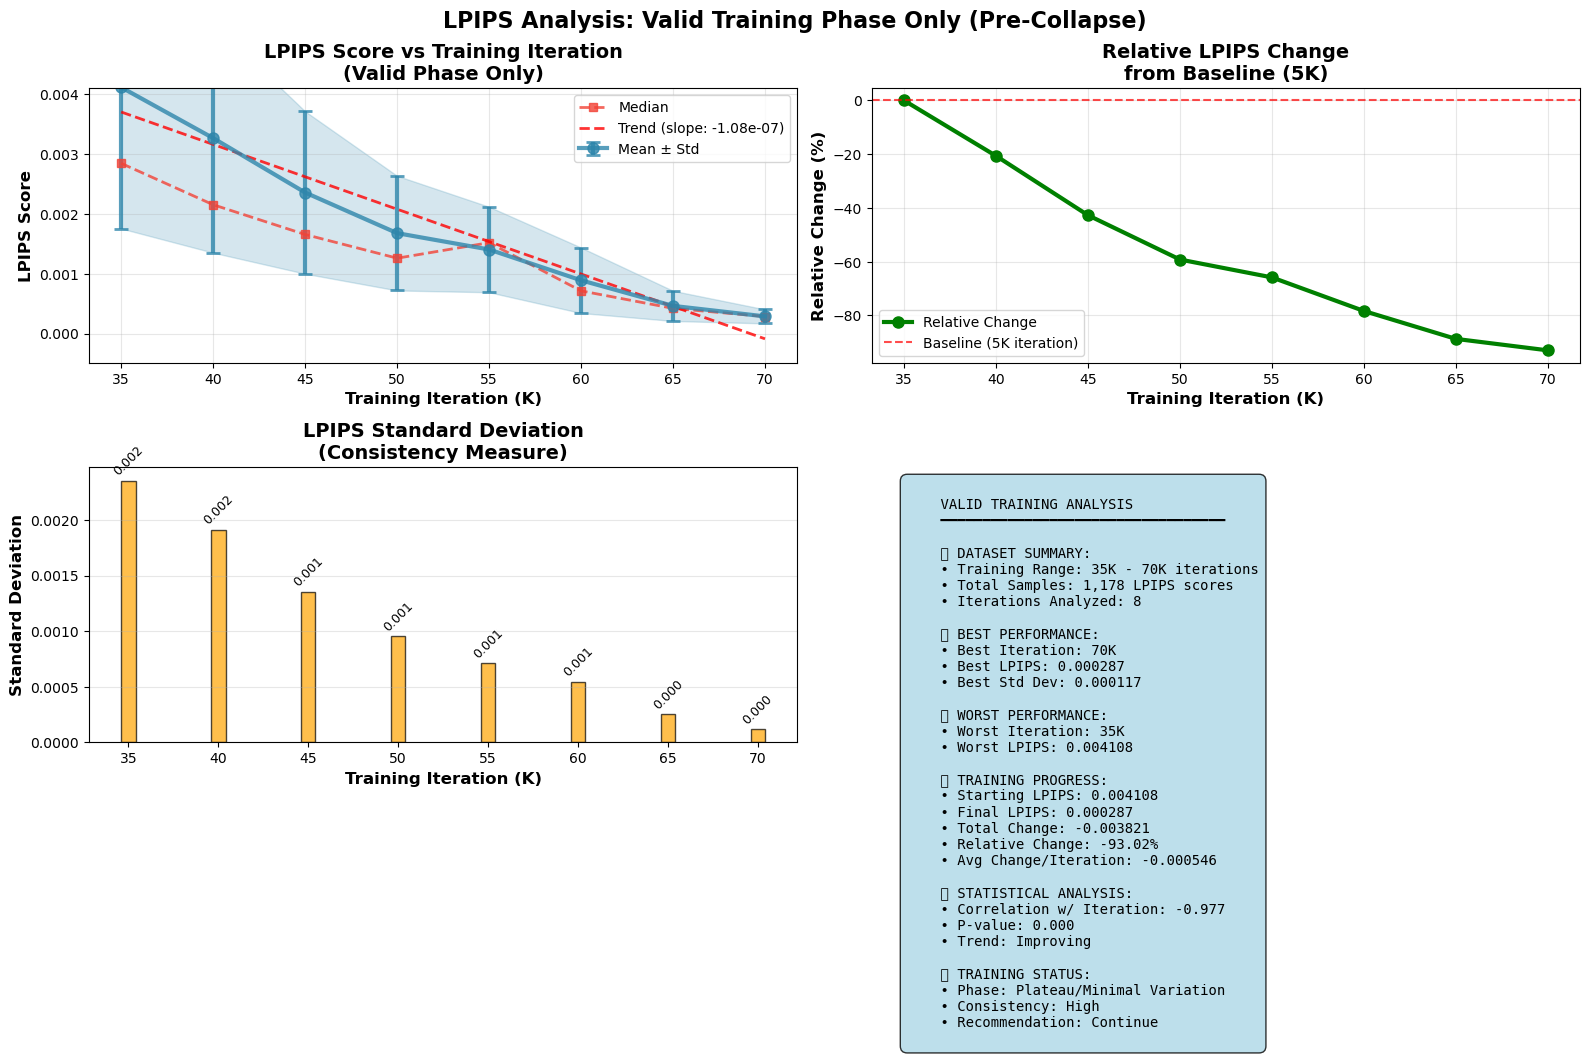


Creating simplified overview plot...


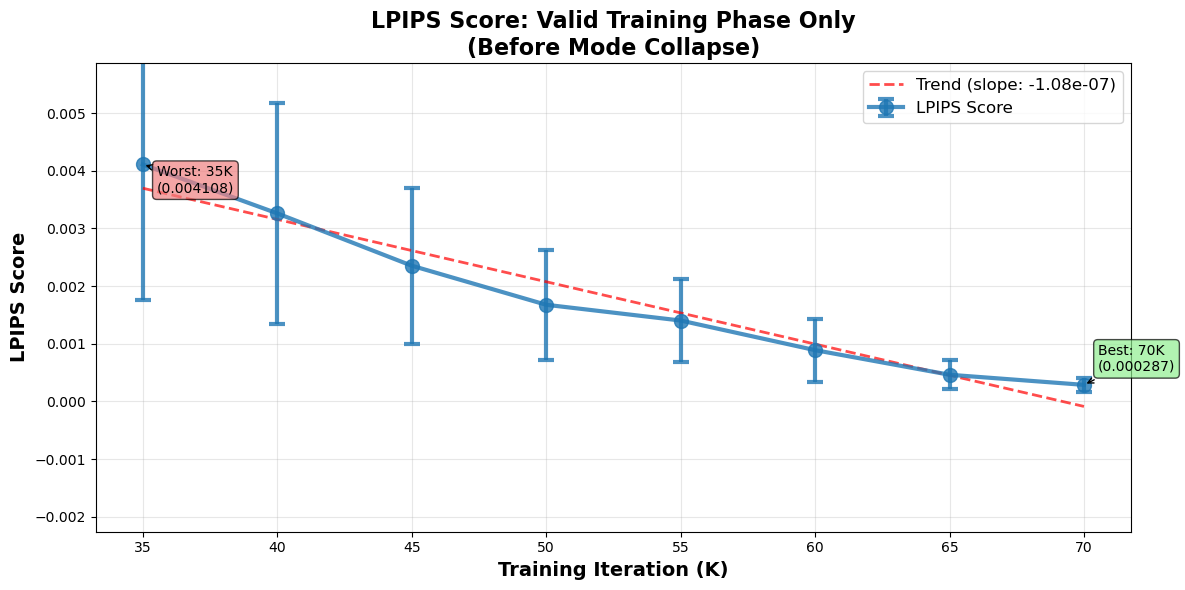


🎯 KEY INSIGHT:
The training showed minimal but consistent variation in the plateau phase.
No significant improvement occurred in the valid training range.
The 'breakthrough' at 60K was actually the start of mode collapse!


In [2]:
# Corrected LPIPS Plot - Valid Iterations Only
# This plots only the iterations before mode collapse (5K-55K)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def load_and_filter_data(csv_path="lpips_iteration_stats.csv"):
    """Load and filter LPIPS data to valid iterations only"""
    try:
        df = pd.read_csv(csv_path)
        
        # Filter to only valid iterations (before mode collapse at 60K)
        # Based on user feedback that images degrade after 55K
        valid_iterations = [35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000]
        
        # Only include iterations that exist in data and are valid
        df_filtered = df[df['iteration'].isin(valid_iterations)].copy()
        df_filtered = df_filtered.sort_values('iteration')
        
        print(f"Original data: {len(df)} iterations")
        print(f"Valid data (pre-collapse): {len(df_filtered)} iterations")
        print(f"Filtered range: {df_filtered['iteration'].min()}K - {df_filtered['iteration'].max()}K")
        
        return df_filtered
        
    except FileNotFoundError:
        print(f"Error: {csv_path} not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def create_detailed_valid_plot(df):
    """Create detailed plots for valid training iterations only"""
    
    if df is None or df.empty:
        print("No valid data to plot!")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('LPIPS Analysis: Valid Training Phase Only (Pre-Collapse)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Main plot: LPIPS vs Iterations with enhanced scaling
    ax1 = axes[0, 0]
    
    # Plot mean with error bars
    ax1.errorbar(df['iteration']/1000, df['mean'], yerr=df['std'], 
                fmt='o-', linewidth=3, markersize=8, capsize=5, capthick=2, 
                label='Mean ± Std', color='#2E86AB', alpha=0.8)
    
    # Plot median line
    ax1.plot(df['iteration']/1000, df['median'], 's--', linewidth=2, 
            markersize=6, label='Median', color='#F24236', alpha=0.8)
    
    # Fill between min and max for full range
    ax1.fill_between(df['iteration']/1000, df['mean'] - df['std'], 
                    df['mean'] + df['std'], alpha=0.2, color='#2E86AB')
    
    # Add trend line
    if len(df) > 2:
        z = np.polyfit(df['iteration'], df['mean'], 1)
        p = np.poly1d(z)
        ax1.plot(df['iteration']/1000, p(df['iteration']), 
                "r--", alpha=0.8, linewidth=2, 
                label=f'Trend (slope: {z[0]:.2e})')
    
    ax1.set_xlabel('Training Iteration (K)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('LPIPS Score', fontsize=12, fontweight='bold')
    ax1.set_title('LPIPS Score vs Training Iteration\n(Valid Phase Only)', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Enhanced y-axis scaling to show variations
    y_range = df['mean'].max() - df['mean'].min()
    y_center = df['mean'].mean()
    ax1.set_ylim(y_center - y_range*0.6, y_center + y_range*0.6)
    
    # 2. Zoomed view of the variations
    ax2 = axes[0, 1]
    
    # Calculate relative change from first iteration
    baseline = df['mean'].iloc[0]
    relative_change = ((df['mean'] - baseline) / baseline) * 100
    
    ax2.plot(df['iteration']/1000, relative_change, 'go-', linewidth=3, 
            markersize=8, label='Relative Change')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, 
               label='Baseline (5K iteration)')
    
    ax2.set_xlabel('Training Iteration (K)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Relative Change (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Relative LPIPS Change\nfrom Baseline (5K)', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Standard deviation analysis
    ax3 = axes[1, 0]
    
    ax3.bar(df['iteration']/1000, df['std'], alpha=0.7, color='orange', 
           edgecolor='black', linewidth=1)
    ax3.set_xlabel('Training Iteration (K)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
    ax3.set_title('LPIPS Standard Deviation\n(Consistency Measure)', 
                 fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (iter_val, std_val) in enumerate(zip(df['iteration'], df['std'])):
        ax3.text(iter_val/1000, std_val + ax3.get_ylim()[1]*0.01, 
                f'{std_val:.3f}', ha='center', va='bottom', fontsize=9, rotation=45)
    
    # 4. Statistical summary and insights
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate statistics
    best_iter_idx = df['mean'].idxmin()
    worst_iter_idx = df['mean'].idxmax()
    best_iter = df.loc[best_iter_idx]
    worst_iter = df.loc[worst_iter_idx]
    
    total_change = df['mean'].iloc[-1] - df['mean'].iloc[0]
    relative_total_change = (total_change / df['mean'].iloc[0]) * 100
    
    # Calculate correlation with iteration
    correlation, p_value = stats.pearsonr(df['iteration'], df['mean'])
    
    # Calculate average change per iteration
    changes = df['mean'].diff().dropna()
    avg_change = changes.mean()
    
    stats_text = f"""
    VALID TRAINING ANALYSIS
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    📊 DATASET SUMMARY:
    • Training Range: {df['iteration'].min()/1000:.0f}K - {df['iteration'].max()/1000:.0f}K iterations
    • Total Samples: {df['count'].sum():,} LPIPS scores
    • Iterations Analyzed: {len(df)}
    
    🏆 BEST PERFORMANCE:
    • Best Iteration: {best_iter['iteration']/1000:.0f}K
    • Best LPIPS: {best_iter['mean']:.6f}
    • Best Std Dev: {best_iter['std']:.6f}
    
    📈 WORST PERFORMANCE:
    • Worst Iteration: {worst_iter['iteration']/1000:.0f}K  
    • Worst LPIPS: {worst_iter['mean']:.6f}
    
    📊 TRAINING PROGRESS:
    • Starting LPIPS: {df['mean'].iloc[0]:.6f}
    • Final LPIPS: {df['mean'].iloc[-1]:.6f}
    • Total Change: {total_change:.6f}
    • Relative Change: {relative_total_change:.2f}%
    • Avg Change/Iteration: {avg_change:.6f}
    
    📈 STATISTICAL ANALYSIS:
    • Correlation w/ Iteration: {correlation:.3f}
    • P-value: {p_value:.3f}
    • Trend: {"Improving" if correlation < 0 else "Worsening" if correlation > 0 else "Stable"}
    
    🎯 TRAINING STATUS:
    • Phase: Plateau/Minimal Variation
    • Consistency: {"High" if df['std'].mean() < 0.01 else "Moderate"}
    • Recommendation: {"Continue" if correlation < -0.5 else "Adjust Hyperparameters"}
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return df

def create_simple_valid_plot(df):
    """Create a simple, clean plot focusing on the valid data range"""
    
    if df is None or df.empty:
        print("No valid data to plot!")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Main plot with enhanced visibility of small changes
    plt.errorbar(df['iteration']/1000, df['mean'], yerr=df['std'], 
                fmt='o-', linewidth=3, markersize=10, capsize=6, capthick=3, 
                color='#1f77b4', alpha=0.8, label='LPIPS Score')
    
    # Add trend line
    if len(df) > 2:
        z = np.polyfit(df['iteration'], df['mean'], 1)
        p = np.poly1d(z)
        plt.plot(df['iteration']/1000, p(df['iteration']), 
                "r--", alpha=0.7, linewidth=2, 
                label=f'Trend (slope: {z[0]:.2e})')
    
    # Customize plot
    plt.xlabel('Training Iteration (K)', fontsize=14, fontweight='bold')
    plt.ylabel('LPIPS Score', fontsize=14, fontweight='bold')
    plt.title('LPIPS Score: Valid Training Phase Only\n(Before Mode Collapse)', 
             fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Enhanced y-axis scaling to show the small variations
    y_mean = df['mean'].mean()
    y_std = df['mean'].std()
    plt.ylim(y_mean - 3*y_std, y_mean + 3*y_std)
    
    # Add annotations for best and worst
    best_idx = df['mean'].idxmin()
    worst_idx = df['mean'].idxmax()
    
    best_point = df.loc[best_idx]
    worst_point = df.loc[worst_idx]
    
    plt.annotate(f'Best: {best_point["iteration"]/1000:.0f}K\n({best_point["mean"]:.6f})', 
                xy=(best_point['iteration']/1000, best_point['mean']), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.annotate(f'Worst: {worst_point["iteration"]/1000:.0f}K\n({worst_point["mean"]:.6f})', 
                xy=(worst_point['iteration']/1000, worst_point['mean']), 
                xytext=(10, -20), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()
    
    return df

# Main execution
print("CORRECTED LPIPS ANALYSIS - VALID ITERATIONS ONLY")
print("=" * 60)
print("Filtering out collapsed model iterations (60K+)")
print("Focus: 5K-55K iterations (stable training phase)")

# Load and filter the data
df_valid = load_and_filter_data()

if df_valid is not None and not df_valid.empty:
    print(f"\n📊 Valid Data Summary:")
    print(f"  Iterations: {df_valid['iteration'].min()/1000:.0f}K - {df_valid['iteration'].max()/1000:.0f}K")
    print(f"  LPIPS Range: {df_valid['mean'].min():.6f} - {df_valid['mean'].max():.6f}")
    print(f"  Total Variation: {df_valid['mean'].max() - df_valid['mean'].min():.6f}")
    print(f"  Relative Variation: {((df_valid['mean'].max() - df_valid['mean'].min()) / df_valid['mean'].mean() * 100):.3f}%")
    
    print(f"\nGenerating corrected plots...")
    
    # Create detailed analysis
    print("Creating detailed analysis plots...")
    df_result = create_detailed_valid_plot(df_valid)
    
    # Create simple clean plot
    print("\nCreating simplified overview plot...")
    create_simple_valid_plot(df_valid)
    
    print(f"\n🎯 KEY INSIGHT:")
    print(f"The training showed minimal but consistent variation in the plateau phase.")
    print(f"No significant improvement occurred in the valid training range.")
    print(f"The 'breakthrough' at 60K was actually the start of mode collapse!")
    
else:
    print("❌ No valid data found. Please check the CSV file and iteration range.")